In [1]:
# imports
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout 
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [57]:
# load the dataset
original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_less_9hrs.csv")

# show the original data
original_dataset.head()

,TaskNumber,Priority,StatusCode,ProjectCode,SubCategory,#Developers,TaskPerformance,DeveloperPerformance,HoursEstimate,HoursLogged,Difference
0,7963,4,COMPLETED,PC9,Release,1,-8.95,-5.95,3.0,11.95,8.95
1,7963,4,COMPLETED,PC9,Release,1,-8.95,NaN,3.0,11.95,8.95
2,12609,1,FINISHED,PC6,Enhancement,1,-8.94,-8.94,35.0,43.94,8.94
3,13397,1,FINISHED,PC5,Testing,1,-8.92,-8.92,14.0,22.92,8.92
4,6063,1,FINISHED,PC9,Enhancement,1,8.82,NaN,35.0,26.18,8.82


In [58]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TaskNumber            4267 non-null   int64  
 1   Priority              4267 non-null   int64  
 2   StatusCode            4267 non-null   object 
 3   ProjectCode           4267 non-null   object 
 4   SubCategory           4267 non-null   object 
 5   #Developers           4267 non-null   int64  
 6   TaskPerformance       4267 non-null   float64
 7   DeveloperPerformance  3830 non-null   float64
 8   HoursEstimate         4267 non-null   float64
 9   HoursLogged           4267 non-null   float64
 10  Difference            4267 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 366.8+ KB


In [59]:
# drop all the unnecessary columns
clean_dataset = original_dataset.drop(columns=[
    'TaskNumber',
    'StatusCode',
    'ProjectCode',
    'TaskPerformance',
    'DeveloperPerformance',
    'Difference',
])

# desnormalizing SubCategory column
valid_subcategories = clean_dataset['SubCategory'].unique()
clean_dataset = pd.get_dummies(clean_dataset, columns=['SubCategory'])
clean_dataset = clean_dataset.astype(int)

# check if is necessary to drop any row with NaN/empty/null values

# drop rows with high desviation on hours 

In [60]:
clean_dataset.head()

,Priority,#Developers,HoursEstimate,HoursLogged,SubCategory_Bug,SubCategory_Enhancement,SubCategory_Release,SubCategory_Testing
0,4,1,3,11,0,0,1,0
1,4,1,3,11,0,0,1,0
2,1,1,35,43,0,1,0,0
3,1,1,14,22,0,0,0,1
4,1,1,35,26,0,1,0,0


In [61]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Priority                 4267 non-null   int32
 1   #Developers              4267 non-null   int32
 2   HoursEstimate            4267 non-null   int32
 3   HoursLogged              4267 non-null   int32
 4   SubCategory_Bug          4267 non-null   int32
 5   SubCategory_Enhancement  4267 non-null   int32
 6   SubCategory_Release      4267 non-null   int32
 7   SubCategory_Testing      4267 non-null   int32
dtypes: int32(8)
memory usage: 133.5 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [62]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.4)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (2560, 8)
    Test: (854, 8)
    Validation: (853, 8)


### Data analysis

Calculate the correlation and other statistics on the train dataset

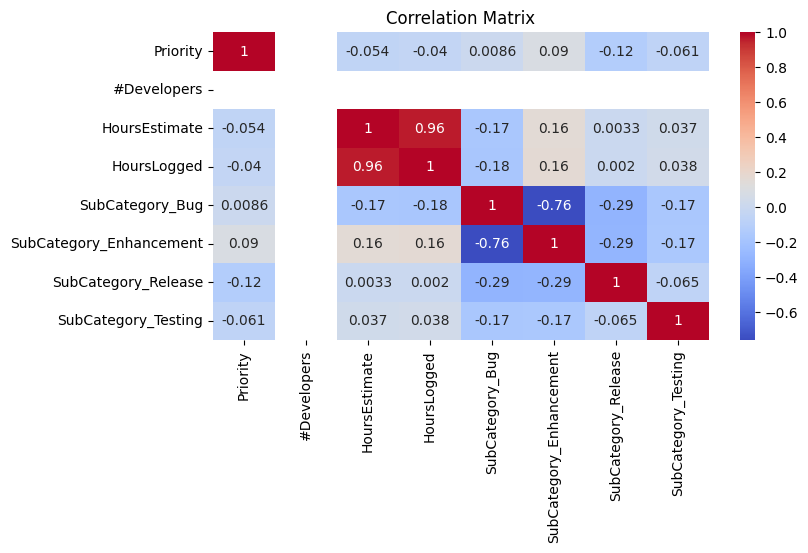

In [63]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['HoursLogged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

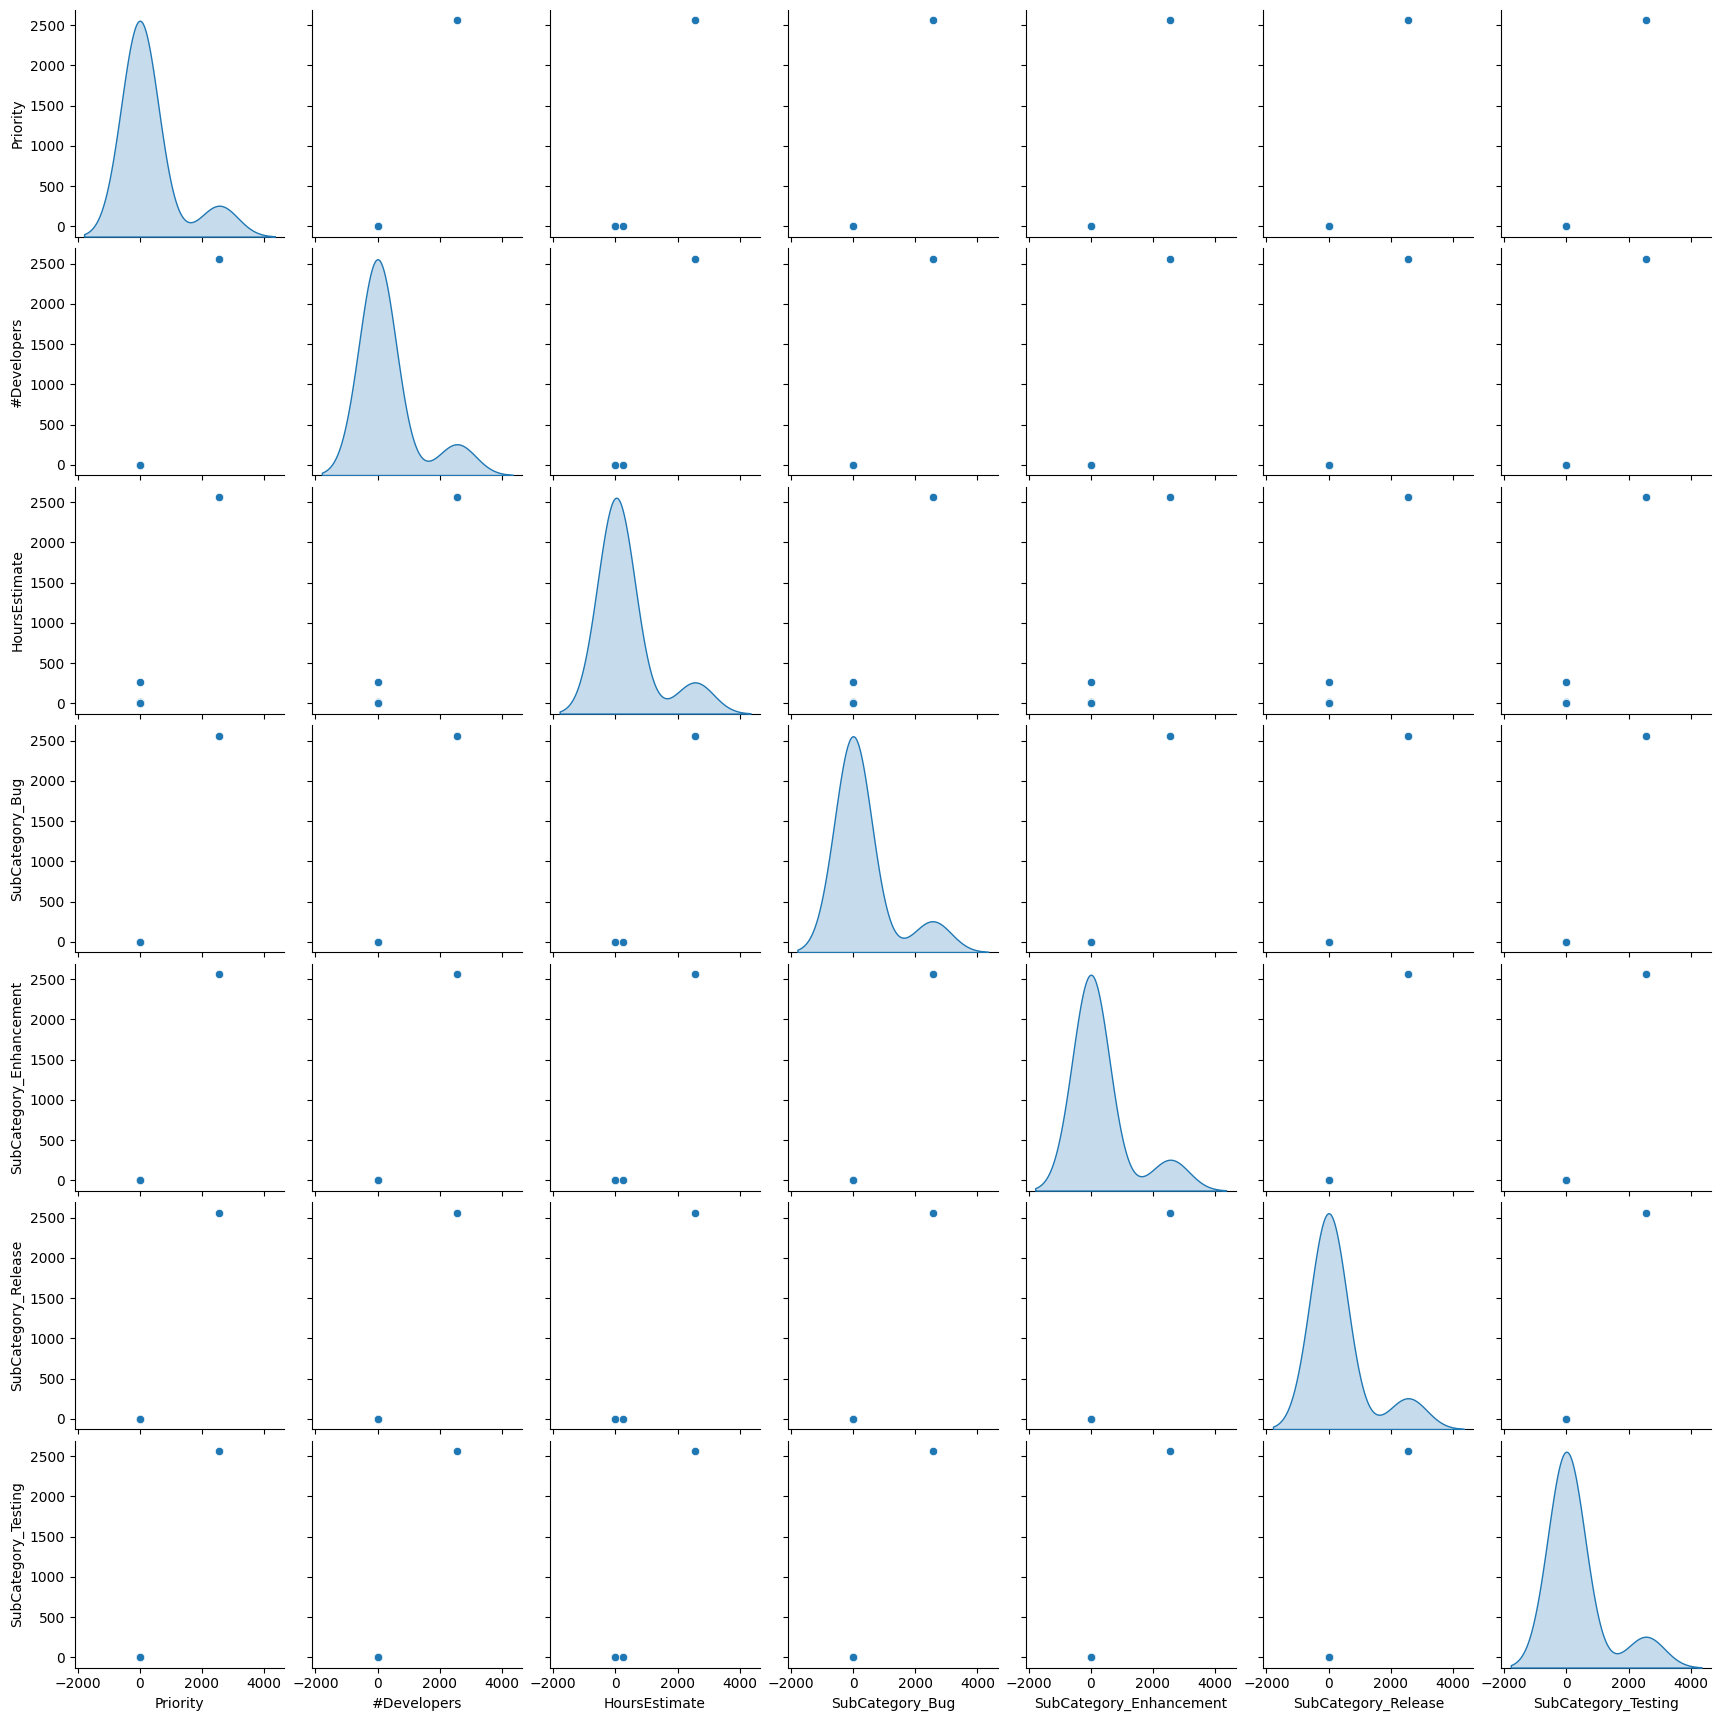

In [64]:
# correlation only between the features 
train_stats = train_dataset.describe()
train_stats.pop("HoursLogged")
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde")

In [65]:
# another interesting statistics 
train_stats = train_dataset.describe()
train_stats.pop("HoursLogged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Priority,2560.0,2.246875,1.776048,1.0,1.0,1.0,3.0,10.0
#Developers,2560.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
HoursEstimate,2560.0,4.679297,9.844506,0.0,1.0,2.0,7.0,260.0
SubCategory_Bug,2560.0,0.443750,0.496923,0.0,0.0,0.0,1.0,1.0
SubCategory_Enhancement,2560.0,0.415234,0.492859,0.0,0.0,0.0,1.0,1.0
SubCategory_Release,2560.0,0.105078,0.306714,0.0,0.0,0.0,0.0,1.0
SubCategory_Testing,2560.0,0.035937,0.186171,0.0,0.0,0.0,0.0,1.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [66]:
train_label = train_dataset.pop('HoursLogged')
test_label = test_dataset.pop('HoursLogged')
validation_label = validation_dataset.pop('HoursLogged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [67]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

# temporaly
# recover the original #Developer column
normed_train_data['#Developers'] = normed_train_data['#Developers'].fillna(1)
normed_test_data['#Developers'] = normed_test_data['#Developers'].fillna(1)
normed_validation_data['#Developers'] = normed_validation_data['#Developers'].fillna(1)


In [68]:
# show a part of the normalized data
normed_train_data.head()

,Priority,#Developers,HoursEstimate,SubCategory_Bug,SubCategory_Enhancement,SubCategory_Release,SubCategory_Testing
1461,0.424045,1.0,0.032577,-0.892996,1.186477,-0.342593,-0.193035
2511,0.424045,1.0,-0.272162,1.119389,-0.842502,-0.342593,-0.193035
1048,-0.139002,1.0,-0.272162,-0.892996,1.186477,-0.342593,-0.193035
4170,-0.702050,1.0,-0.475321,-0.892996,-0.842502,2.917773,-0.193035
2454,-0.702050,1.0,-0.069003,-0.892996,-0.842502,-0.342593,5.178379


## Building the Neural Network Model

## Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [69]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [70]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(32, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(128, Activation('relu'), name='hidden_layer_3'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Third Model

Five hidden layers, all with 64 neurons

Learning rate at 0.001

In [71]:
def build_third_model_five_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(64, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_4'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_5'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Choose the model

To choose the model uncomment the line of the one that you want yo fit

In [76]:
# model = build_first_model_two_hidden_layers()
# model = build_second_model_three_hidden_layers()
model = build_third_model_five_hidden_layers()

Test the model before training (this will use the initial weights) which in fact will generate random values. We will take the first 10 rows

In [77]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 217ms/step


array([[-0.11524377],
       [-0.01417719],
       [-0.05079468],
       [ 0.19921963],
       [-0.08314367],
       [-0.02790281],
       [-0.01696723],
       [-0.02585536],
       [ 0.00837311],
       [ 0.01126646]], dtype=float32)

Save checkpoints during training

In [74]:
checkpoint_path = r".\checkpoint_logs\external\data.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
                                                  )

## Model training

In [80]:
%%time

# for first model - is winning
epochs = 200
batch_size = 30

# for second model
# epochs = 600
# batch_size = 100
# for third model

print("Summary of the model")
model.summary()

history = model.fit(
    normed_train_data,
    train_label,
    batch_size=batch_size,  
    epochs=epochs, 
    verbose=0,
    shuffle=True,
    steps_per_epoch = int(normed_train_data.shape[0] / batch_size),
    validation_data=(normed_validation_data, validation_label),
    callbacks=[
        tfdocs.modeling.EpochDots(),
        ckpt_callback,
    ]
)

Summary of the model
Model: "SecondModelThreeHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                80        
                                                                 
 hidden_layer_1 (Dense)      (None, 64)                704       
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_3 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_4 (Dense)      (None, 64)                4160      
                                                                 
 hidden_layer_5 (Dense)      (None, 64)                4160      
                                                                 
 dense_9 (Dense) 

In [42]:
print("Summary of the results after each epoch:")
history_dataset = pd.DataFrame(history.history)
history_dataset['epoch'] = history.epoch
history_dataset.tail()

Summary of the results after each epoch:


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
795,55.119072,4.185913,55.119072,147.331360,4.592845,147.331360,795
796,46.981201,4.014155,46.981201,147.805359,4.756784,147.805359,796
797,51.048721,4.097038,51.048721,147.489517,4.734643,147.489517,797
798,51.115051,4.012751,51.115051,147.480881,4.566053,147.480881,798
799,54.907532,4.081649,54.907532,147.399658,4.719727,147.399658,799


### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [43]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print("Predicted Hours Logged")
example_result

1/1 [==============================] - 0s 63ms/step
Predicted Hours Logged


array([[4.5796556],
       [3.066094 ],
       [6.2466955],
       [6.2466955],
       [3.066094 ],
       [4.1912127],
       [4.5796556],
       [6.2466955],
       [3.2318985],
       [3.2318985]], dtype=float32)

In [44]:
print("Real Hours Logged")
train_label[:10]

Real Hours Logged


1098     4
2950     7
297     11
1197     4
1893     2
3522     2
4050     2
3615     0
3935     1
3704     1
Name: HoursLogged, dtype: int32

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

We will graph the error metrics across epochs and then see how the model evalutes itself

Text(0, 0.5, 'MAE [Hours Logged]')

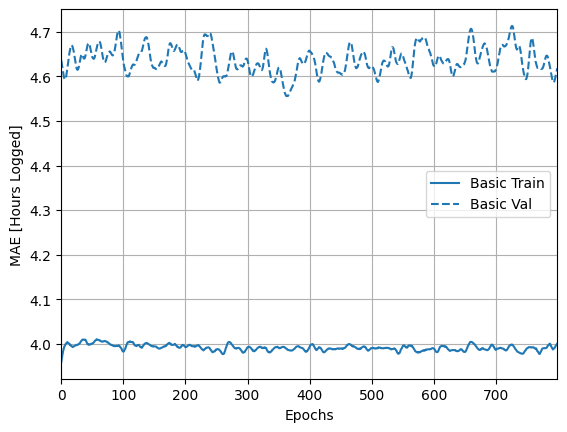

In [31]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Hours Logged]')

In [32]:
print("Error Rate on Train Sample")
loss, mae, mse = model.evaluate(normed_train_data, train_label, verbose=2)

print("Train set Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Train set Mean Squared Error: {:5.2f} Hours Logged".format(mse))


Error Rate on Train Sample
80/80 - 0s - loss: 49.6741 - mae: 4.0070 - mse: 49.6741 - 320ms/epoch - 4ms/step
Train set Mean Abs Error:  4.01 Hours Logged
Train set Mean Squared Error: 49.67 Hours Logged


In [33]:
print("Error Rate on Validation Sample")
loss, mae, mse = model.evaluate(normed_validation_data, validation_label, verbose=2)

print("Train set Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Train set Mean Squared Error: {:5.2f} Hours Logged".format(mse))

Error Rate on Validation Sample
27/27 - 0s - loss: 147.1088 - mae: 4.6475 - mse: 147.1088 - 164ms/epoch - 6ms/step
Train set Mean Abs Error:  4.65 Hours Logged
Train set Mean Squared Error: 147.11 Hours Logged


## Predicting the data

27/27 [==============================] - 0s 4ms/step


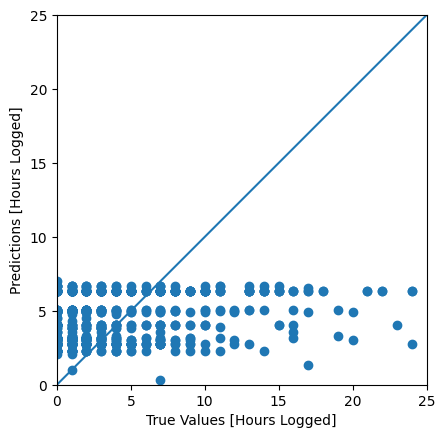

In [34]:
test_predictions = model.predict(normed_test_data).flatten()

axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
lims = [0, 25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
